In [1]:
## 개선사항 (0520)
# 1. stopwords 추가
# 2. 최적의 토픽 개수 선정

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager, rc

import warnings
warnings.filterwarnings(action='ignore')
from konlpy.tag import Kkma
import re 
from gensim import corpora
import gensim
from collections import Counter

In [3]:
reviews = pd.read_csv('../data/unique_reviews.csv', encoding='utf-8-sig', index_col=0)

In [4]:
# 평점 5점이상만 긍정 / 나머지는 부정 기준 감성분석 데이터


reviews_pos_neg = pd.read_csv('../data/final_musinsa_review_data_5점이상 긍정.csv', encoding='utf-8-sig', index_col=0)

In [5]:
reviews_pos_neg['group'].unique()

array(['긍정(평점) & 긍정(모델)', '긍정(평점) & 부정(모델)', '부정(평점) & 긍정(모델)',
       '부정(평점) & 부정(모델)'], dtype=object)

In [6]:
# 데이터 전처리

reviews_pos_neg['review'] = reviews_pos_neg['review'].str.replace('\n', ' ')
reviews = list(map(lambda review: re.sub('[^가-힣 ]', '', review), reviews_pos_neg['review']))
reviews_pos_neg['review'] = reviews

In [7]:
# 4개의 그룹으로 분리

group1 = reviews_pos_neg[reviews_pos_neg['group'] == '긍정(평점) & 긍정(모델)']['review']
group2 = reviews_pos_neg[reviews_pos_neg['group'] == '긍정(평점) & 부정(모델)']['review']
group3 = reviews_pos_neg[reviews_pos_neg['group'] == '부정(평점) & 긍정(모델)']['review']
group4 = reviews_pos_neg[reviews_pos_neg['group'] == '부정(평점) & 부정(모델)']['review']

In [8]:
# kkma로 토큰화 진행 시 group1 에서 java.lang.OutOfMemoryError: Java heap space 에러가 뜬다.

print(len(group1), len(group2), len(group3), len(group4))


# Group1의 리뷰 수는 99794개로, 5000개의 샘플을 뽑아 진행하였다.

99794 11414 3119 339


In [9]:
group1 = group1.sample(5000)

In [10]:
# 토큰화

from konlpy.tag import Kkma
kkma = Kkma()

review_tokenized_g1 = list(map(lambda review: kkma.nouns(review), group1))
review_tokenized_g2 = list(map(lambda review: kkma.nouns(review), group2))
review_tokenized_g3 = list(map(lambda review: kkma.nouns(review), group3))
review_tokenized_g4 = list(map(lambda review: kkma.nouns(review), group4))

In [11]:
# 불용어 - 모델링 테스트 후, topic을 정하는 키워드의 의미를 가지지 않는 한글자 단어만 모아 stopwords 리스트를 만들었다.


stopwords_list = ['거', '날', '수', '이', '뭐', '배', '저', '때', '사', '마', '분', '넘', '여', '감', '꿈', '정', '발', '별', '개', '해', '듯', '수', '용']

In [12]:
# 불용어 제거 - 불용어에 포함되어 있지 않은 토큰만 분석

def remove_stopword(tokens):
    removed = []
    for token in tokens:
        if token not in stopwords_list:
            removed.append(token)
    return removed

In [13]:
review_tokenized_g1_sw = list(map(lambda tokens : remove_stopword(tokens), review_tokenized_g1))
review_tokenized_g2_sw = list(map(lambda tokens : remove_stopword(tokens), review_tokenized_g2))
review_tokenized_g3_sw = list(map(lambda tokens : remove_stopword(tokens), review_tokenized_g3))
review_tokenized_g4_sw = list(map(lambda tokens : remove_stopword(tokens), review_tokenized_g4))

In [14]:
# 특정 토큰 개수 리뷰 선별 - 하나의 리뷰 당 최소 토큰 개수를 3, 최대 토큰 개수를 15로 제한

def select_review(reviews):
    review_prep = []
    for tokens in reviews:
        if 3 <= len(tokens) <= 15:
            review_prep.append(tokens)
    return review_prep

In [15]:
group1_tokens = select_review(review_tokenized_g1_sw)
group2_tokens = select_review(review_tokenized_g2_sw)
group3_tokens = select_review(review_tokenized_g3_sw)
group4_tokens = select_review(review_tokenized_g4_sw)

In [16]:
group1_tokens

[['볼', '로', '주문햤다', '으', '교환'],
 ['배송', '핏', '구두', '처음', '편안', '걱정', '사이즈', '후기', '보고', '로', '다', '사은품', '양말'],
 ['적당', '길이', '제가', '구두', '단위', '끈', '조정', '가능'],
 ['폭',
  '폭신해',
  '신해',
  '척추',
  '읕',
  '정사이즈',
  '사이즈',
  '구입',
  '발끝',
  '단위',
  '반',
  '반업',
  '업'],
 ['발볼조절', '볼', '조절', '편안', '슬리퍼', '추', '추찬', '찬'],
 ['사이즈', '정사이즈', '상자', '이것', '내', '다리', '무사', '생각', '치'],
 ['사이즈', '반', '반다운', '다운', '터'],
 ['사이즈', '정사이즈라', '라', '고민', '끈'],
 ['성비', '굽이', '적응', '시간'],
 ['키', '키높이효과', '높이', '효과', '성비'],
 ['베이지', '베이지색', '색', '정사이즈', '사이즈', '양말', '신고', '생각'],
 ['친구', '칭찬', '신발', '데일리', '무리', '추천'],
 ['편안',
  '스타일',
  '스타일리시한',
  '리',
  '시한',
  '제품',
  '착화',
  '착화감이',
  '감이',
  '면바지',
  '통기성',
  '무게감',
  '생각'],
 ['평소', '신발', '신고', '칼', '칼발', '발볼', '볼', '편', '앞쪽', '뒷', '스트랩', '주진', '불편'],
 ['깡', '깡님', '님', '항', '코디', '대', '만족', '무', '다드', '콜라', '앞'],
 ['여유', '와요', '레인', '레인부츠', '부츠', '첨'],
 ['원래', '사이즈', '하면', '뒷', '뒷꿈', '편', '길', '밴드', '필수'],
 ['첨', '데', '질'],
 ['굽', '사이즈', '심플'],
 ['엄마', '

In [17]:
# 토픽 개수 최적화

dictionary = corpora.Dictionary(group1_tokens)
corpus = [dictionary.doc2bow(review) for review in group4_tokens]

In [18]:
from gensim.models import CoherenceModel

coherence_values = []
for i in range(2, 15):
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=i, id2word=dictionary)
    coherence_model_lda = CoherenceModel(model=ldamodel, texts=group1_tokens, dictionary=dictionary, topn=10)
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_values.append(coherence_lda)

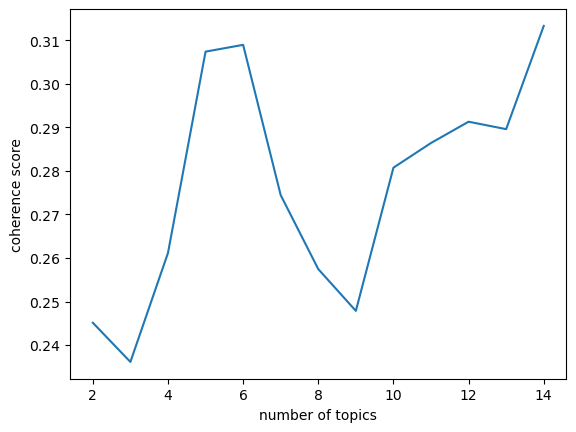

In [19]:
x = range(2,15)
plt.plot(x, coherence_values)
plt.xlabel("number of topics")
plt.ylabel("coherence score")
plt.show()

In [20]:
# 최적 토픽 개수는 6개, 모델 학습 횟수는 15개로 임시 지정

NUM_TOPICS = 6
PASSES = 15

In [21]:
# 모델 학습 함수

# Gensim에는 LDA  모델링을 수행하는 클래스 gensim.models의 LdaModel이 있다. 매개변수로는
# corpus : doc2bow()를 이용해 변환된 카운트 벡터 리스트
# num_topics : 토픽의 수
# id2word : dictionary
# passes는 Sklearn의 max_ iter


def lda_modeling(review_prep):
    dictionary = corpora.Dictionary(review_prep)
    corpus = [dictionary.doc2bow(review) for review in review_prep]
    
    model = gensim.models.ldamodel.LdaModel(corpus, 
                                            num_topics = NUM_TOPICS, 
                                            id2word = dictionary, 
                                            passes = PASSES)
    return model, corpus, dictionary

In [22]:
# 토픽별 단어 구성 출력 함수

def print_topic_prop(topics, group):
    topic_values = []
    for topic in topics:
        topic_value = topic[1]
        topic_values.append(topic_value)
        
    # topic_prop = pd.DataFrame({"topic_num" : list(range(1, NUM_TOPICS + 1)), "word_prop": topic_values})
    # topic_prop.to_excel(group + '_topics.xlsx')

    # display(topic_prop)

    display(topic_values)

In [63]:
# 토픽별 구성 단어(NUM_WORDS)는 총 7개로 설정(임시)

# 긍정&부정 리뷰그룹

model, corpus, dictionary = lda_modeling(group2_tokens)
NUM_WORDS = 7

In [64]:
group = 'group2'
topics = model.print_topics(num_words = NUM_WORDS)
print_topic_prop(topics, group)

['0.053*"가격" + 0.033*"구매" + 0.028*"여름" + 0.023*"신" + 0.023*"만족" + 0.022*"대비" + 0.018*"신고"',
 '0.090*"여름" + 0.053*"신기" + 0.024*"신고" + 0.022*"신발" + 0.019*"구매" + 0.017*"이번" + 0.013*"하나"',
 '0.027*"구매" + 0.024*"키" + 0.019*"부츠" + 0.017*"높이" + 0.015*"만족" + 0.013*"키높이" + 0.013*"블랙"',
 '0.142*"사이즈" + 0.025*"볼" + 0.024*"평소" + 0.024*"정사이즈" + 0.020*"업" + 0.019*"신발" + 0.018*"구매"',
 '0.061*"착화" + 0.049*"만족" + 0.043*"성비" + 0.034*"구매" + 0.027*"배송" + 0.026*"감도" + 0.024*"디자인"',
 '0.030*"신고" + 0.030*"신발" + 0.021*"생각" + 0.021*"고민" + 0.020*"처음" + 0.016*"불편" + 0.014*"디자인"']

### 긍정&부정 토픽 분석
- 평점 5점 + 감성분석 모델 예측 "부정"으로 분류된 리뷰:
    - 토픽1 : 가격에 대한 만족 - 가격 대비 만족한다는 내용
    - 토픽2 : 여름에 신기 좋은 신발로써의 구매에 대한 만족
    - 토픽3 : 부츠의 굽, 키높이에 대한 만족으로 추측
    - 토픽4 : 사이즈에 대한 만족 - 정사이즈, 업 등을 언급하는 디테일한 추천
    - 토픽5 : 착화감에 대한 만족에 더불어 배송, 디자인에 대한 전반적인 만족
    - 토픽6 : 생각보다, 고민, 불편,.. 등의 키워드로 보아 큰 만족도를 언급하지는 않음.

- 대체로 "가격", "사이즈", "착화감"에 대한 만족을 드러낸다.
- 예측상 "부정"적인 감정으로 분류된 리뷰들이지만, 전반적으로는 긍정적인 키워드 중심이다.
- 별점 5점 리뷰의 특성상 부정적인 면이 있어도 어느정도 만족하였기에 평점을 5점 준 것 같다.

---

In [ ]:
# 개인적으로 추가적인 분석 하였습니다

In [33]:
# 토픽별 구성 단어(NUM_WORDS)는 총 7개로 설정(임시)

# 긍정&긍정 리뷰그룹

model, corpus, dictionary = lda_modeling(group1_tokens)
NUM_WORDS = 7

In [34]:
group = 'group1'
topics = model.print_topics(num_words = NUM_WORDS)
print_topic_prop(topics, group)

['0.076*"신발" + 0.054*"신고" + 0.031*"성비" + 0.030*"신어" + 0.029*"양말" + 0.029*"평소" + 0.028*"사이즈"',
 '0.084*"사이즈" + 0.067*"정사이즈" + 0.052*"신발" + 0.048*"추천" + 0.032*"처음" + 0.030*"발등" + 0.030*"편"',
 '0.050*"신발" + 0.042*"맘" + 0.041*"구매" + 0.032*"데" + 0.030*"여름" + 0.030*"맨발" + 0.024*"신고"',
 '0.061*"사이즈" + 0.027*"볼" + 0.022*"정사이즈" + 0.022*"색감" + 0.022*"발볼" + 0.018*"착화" + 0.017*"핏"',
 '0.035*"만족" + 0.028*"가격" + 0.022*"디자인" + 0.021*"배송" + 0.019*"구매" + 0.016*"마음" + 0.016*"신고"',
 '0.043*"느낌" + 0.032*"구매" + 0.026*"운동화" + 0.026*"부분" + 0.024*"바닥" + 0.024*"치수" + 0.024*"구두"']

In [55]:
# 부정&부정 리뷰 그룹

model, corpus, dictionary = lda_modeling(group4_tokens)
NUM_WORDS = 7

In [56]:
group = 'group4'
topics = model.print_topics(num_words = NUM_WORDS)
print_topic_prop(topics, group)

['0.041*"사이즈" + 0.028*"배송" + 0.018*"신고" + 0.016*"가격" + 0.015*"생각" + 0.013*"부분" + 0.012*"성비"',
 '0.024*"배송" + 0.022*"제품" + 0.021*"사이즈" + 0.014*"가격" + 0.012*"교환" + 0.012*"신고" + 0.010*"냄새"',
 '0.027*"신발" + 0.020*"마감" + 0.018*"발등" + 0.017*"자체" + 0.015*"사이즈" + 0.014*"느낌" + 0.011*"생각"',
 '0.021*"발가락" + 0.019*"발등" + 0.018*"처음" + 0.018*"사이" + 0.016*"신고" + 0.013*"사이즈" + 0.013*"엄지"',
 '0.026*"신발" + 0.018*"생각" + 0.018*"착화" + 0.018*"반품" + 0.016*"부분" + 0.015*"발등" + 0.015*"디자인"',
 '0.028*"발등" + 0.027*"착화" + 0.027*"사이즈" + 0.025*"디자인" + 0.019*"신기" + 0.015*"신발" + 0.014*"불편"']

### (추가 분석)

- 1. 평점 5점 + 감성모델 예측 모두 "긍정"으로 분류된 리뷰:
    - 토픽1 : 사이즈에 대한 만족 - 양말 신고 신을 때 만족하는 사이즈로 추측
    - 토픽2 : 사이즈에 대한 만족 - 정사이즈를 추천, 발등이 편함을 언급.
    - 토픽3 : 여름, 맨발 키워드와 함께 여름에 신기 좋아 만족하는 리뷰
    - 토픽4 : 상품에 대한 만족 - 사이즈에 더불어 색감, 착화, 발볼, 핏에 대한 전반적인 만족
    - 토픽5 : 구매에 대한 만족 - 가격, 디자인, 배송에 만족
    - 토픽6 : 신발의 바닥 부분과 치수에 대한 언급

- 2. 평점 5점 미만 + 감성모델 예측 모두 "부정"으로 분류된 리뷰:
    - 토픽1 : 사이즈에 대한 불만족 
    - 토픽2 : 제품 배송에 대한 문제, 혹은 교환 의사를 언급
    - 토픽3 : 신발의 마감 문제, 발등에 대한 불만족 언급
    - 토픽4 : 착화감 불만족 - 발가락의 착화감 문제 언급
    - 토픽5 : 착화감 불만족 - 발등의 착화감 문제로 인한 반품 등의 키워드 언급
    - 토픽6 : 착화감 불만족 - 발등의 착화감이 불편하다.

- 전반적으로 긍정적인 리뷰 / 부정적인 리뷰 둘 다 "사이즈"를 많이 언급한다.
- 긍정적인 리뷰에서 특히 사이즈에 대한 키워드가 많은 것으로 보아 "사이즈"는 신발 구매자들의 만족/불만족을 좌우하는 중요한 요소이다.
- 사이즈를 언급하는 리뷰는 주로 (정사이즈를/혹은 한치수 up을) "추천"한다.
- 부정적인 리뷰는 사이즈에 더불어 "착화감"을 많이 언급하는 경향이 있다.
- 착화감에 더불어 발가락/발등 등의 특정 부위에 대한 불편함을 언급한다.
- 신발의 착화감은 잘못된 사이즈에서 비롯될 가능성이 크므로, 사이즈 미스로 인한 불만족으로 예상할 수 있다.
- 배송에 대한 불만족, 제품 품질에 대한 불만족이 그 뒤를 잇는다.